# Seasonality of the Mixed Layer Depth (MLD) Group 
* Part 2 - Application Widget
OOI Data Labs Workshop - August 2019

Revised Feb 11, 2020

**Working Title**: Seasonal Variability In The Mixed Layer 

**Short Description**: How and why does the mixed layer depth in the ocean vary

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import dask
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Setup default plot styles
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

## Request Data from OOINet (run only once)

The first notebook for this widget processed data for the Irminger Sea Array.  This notebook adds in data from Station Papa.  Like the first notebook, Irradiance and Wind Speed data will come from ECMWF reanalysis from a co-located gridpoint.

In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# Data Requests
ctds_GI = ['GI03FLMB-RIM01-02-CTDMOG060',
 'GI03FLMB-RIM01-02-CTDMOG061',
 'GI03FLMB-RIM01-02-CTDMOG062',
 'GI03FLMB-RIM01-02-CTDMOG063',
 'GI03FLMB-RIM01-02-CTDMOG064',
 'GI03FLMB-RIM01-02-CTDMOG065',
 'GI03FLMB-RIM01-02-CTDMOG066',
 'GI03FLMB-RIM01-02-CTDMOG067',
 'GI03FLMB-RIM01-02-CTDMOG068',
 'GI03FLMB-RIM01-02-CTDMOH069',
 'GI03FLMB-RIM01-02-CTDMOH070']

ctds_GP = ['GP03FLMB-RIM01-02-CTDMOG060',
 'GP03FLMB-RIM01-02-CTDMOG061',
 'GP03FLMB-RIM01-02-CTDMOG062',
 'GP03FLMB-RIM01-02-CTDMOG063',
 'GP03FLMB-RIM01-02-CTDMOG064',
 'GP03FLMB-RIM01-02-CTDMOG065',
 'GP03FLMB-RIM01-02-CTDMOG066',
 'GP03FLMB-RIM01-02-CTDMOG067',
 'GP03FLMB-RIM01-02-CTDMOG068',
 'GP03FLMB-RIM01-02-CTDMOH069',
 'GP03FLMB-RIM01-02-CTDMOH070']

# for ctd in ctds_GP:
#   print(ctd)
#   response = request_data(ctd,'recovered_inst','ctdmo_ghqr_instrument_recovered')
#   print(response)


## 2. Load Data Files

In [0]:
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  selected_datasets = sorted(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
url_ctd_GI={}
url_ctd_GI['30m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175239257Z-GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['40m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175239672Z-GI03FLMB-RIM01-02-CTDMOG061-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['60m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175239950Z-GI03FLMB-RIM01-02-CTDMOG062-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['90m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175240318Z-GI03FLMB-RIM01-02-CTDMOG063-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['130m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175240608Z-GI03FLMB-RIM01-02-CTDMOG064-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['180m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175241289Z-GI03FLMB-RIM01-02-CTDMOG065-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['250m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175242149Z-GI03FLMB-RIM01-02-CTDMOG066-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['350m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175243013Z-GI03FLMB-RIM01-02-CTDMOG067-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['500m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175243747Z-GI03FLMB-RIM01-02-CTDMOG068-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['750m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175740568Z-GI03FLMB-RIM01-02-CTDMOH069-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GI['1000m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200116T175716474Z-GI03FLMB-RIM01-02-CTDMOH070-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'


In [0]:
url_ctd_GP={}
url_ctd_GP['30m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160839439Z-GP03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['40m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160839740Z-GP03FLMB-RIM01-02-CTDMOG061-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['60m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160840065Z-GP03FLMB-RIM01-02-CTDMOG062-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['90m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160840356Z-GP03FLMB-RIM01-02-CTDMOG063-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['130m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160840626Z-GP03FLMB-RIM01-02-CTDMOG064-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['180m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160840953Z-GP03FLMB-RIM01-02-CTDMOG065-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['250m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160841270Z-GP03FLMB-RIM01-02-CTDMOG066-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['350m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160841582Z-GP03FLMB-RIM01-02-CTDMOG067-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['500m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160841890Z-GP03FLMB-RIM01-02-CTDMOG068-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['750m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160842186Z-GP03FLMB-RIM01-02-CTDMOH069-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
url_ctd_GP['1000m'] = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200211T160842467Z-GP03FLMB-RIM01-02-CTDMOH070-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'


In [9]:
# Load all Temperature datasets - Daily averaged
ctd_temp_GI = xr.Dataset()
for ctd in url_ctd_GI.keys():
  # Load Data
  print('Loading: %s' % ctd)
  data = get_data(url_ctd_GI[ctd])
  # Remove Outliers
  data['ctdmo_seawater_temperature'] = data['ctdmo_seawater_temperature'].where(reject_outliers(data['ctdmo_seawater_temperature']))
  d = data['ctdmo_seawater_temperature'].load().resample(time='1D').mean()
  d = d.to_dataset().rename({'ctdmo_seawater_temperature': 'GI '+ctd})
  ctd_temp_GI = xr.merge([ctd_temp_GI, d])

Loading: 30m
Loading: 40m
Loading: 60m
Loading: 90m
Loading: 130m
Loading: 180m
Loading: 250m
Loading: 350m
Loading: 500m
Loading: 750m
Loading: 1000m


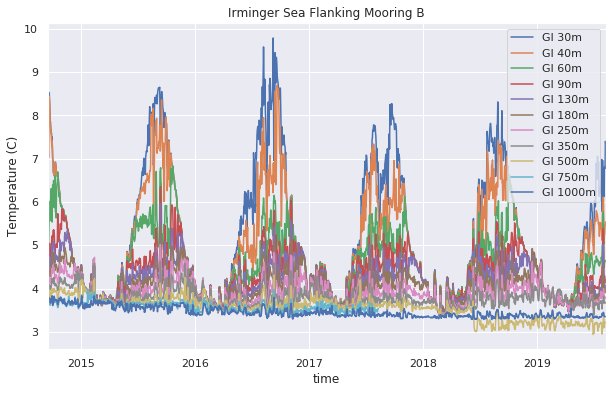

In [10]:
# Plot of daily average
fig,ax = plt.subplots(1,1,figsize=(10,6))
ctd_temp_GI.to_dataframe().plot(ax=ax);
ax.set_ylabel('Temperature (C)')
plt.legend(loc=1)
plt.title('Irminger Sea Flanking Mooring B')
plt.savefig('GI_temperatures.png');

In [11]:
# Load all Temperature datasets - Daily averaged
ctd_temp_GP = xr.Dataset()
for ctd in url_ctd_GP.keys():
  # Load Data
  print('Loading: %s' % ctd)
  data = get_data(url_ctd_GP[ctd])
  # Remove Outliers
  data['ctdmo_seawater_temperature'] = data['ctdmo_seawater_temperature'].where(reject_outliers(data['ctdmo_seawater_temperature']))
  d = data['ctdmo_seawater_temperature'].load().resample(time='1D').mean()
  d = d.to_dataset().rename({'ctdmo_seawater_temperature': 'GP '+ctd})
  ctd_temp_GP = xr.merge([ctd_temp_GP, d])



Loading: 30m
Loading: 40m
Loading: 60m
Loading: 90m
Loading: 130m
Loading: 180m
Loading: 250m
Loading: 350m
Loading: 500m
Loading: 750m
Loading: 1000m


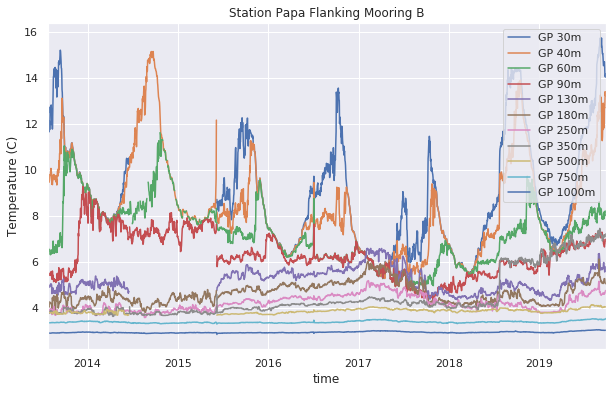

In [12]:
# Plot of daily average
fig,ax = plt.subplots(1,1,figsize=(10,6))
ctd_temp_GP.to_dataframe().plot(ax=ax);
ax.set_ylabel('Temperature (C)')
plt.legend(loc=1)
plt.title('Station Papa Flanking Mooring B')
plt.savefig('GP_temperatures.png');

In [0]:
# Filter and average other datasets
# alldata = xr.merge([ctd_temp_GI,ctd_temp_GP])

## Model Data for the Surface
Because the surface mooring is so gappy, we will grab wind and irradiance data from ERA5.  See appendix for more.

In [0]:
# Open dataset
era5_GI = xr.open_dataset('era5data.nc')

# Combine historical and recent variables
era5_GI['u10'] = era5_GI.u10_0001.combine_first(era5_GI.u10_0005)
era5_GI['v10'] = era5_GI.v10_0001.combine_first(era5_GI.v10_0005)
era5_GI['sst'] = era5_GI.sst_0001.combine_first(era5_GI.sst_0005)
era5_GI['ssrd'] = era5_GI.ssrd_0001.combine_first(era5_GI.ssrd_0005)

# Calculate Wind Speed
era5_GI['ws'] = (era5_GI.u10**2 + era5_GI.v10**2)**.5

# Convert from K to C
era5_GI['sst2'] = era5_GI['sst'] - 273.15 

# Convert J/m^2 to W/m^2 for Irradiance
era5_GI['irr'] = era5_GI['ssrd']/3600

# Average grid points
era5_GI['ws_avg'] = era5_GI['ws'].mean(dim=['longitude','latitude'])
era5_GI['sst_avg'] = era5_GI['sst2'].mean(dim=['longitude','latitude'])
era5_GI['irr_avg'] = era5_GI['irr'].mean(dim=['longitude','latitude'])

# Daily Means
era5b_GI = era5_GI[['ws_avg','sst_avg','irr_avg']].resample(time='1D').mean()
era5b_GI = era5b_GI.rename({'ws_avg':'GI_ws_avg','sst_avg':'GI_sst_avg','irr_avg':'GI_irr_avg'})

In [0]:
era5_GP = xr.open_dataset('era5data_GP.nc')

# Combine historical and recent variables
era5_GP['u10'] = era5_GP.u10_0001.combine_first(era5_GP.u10_0005)
era5_GP['v10'] = era5_GP.v10_0001.combine_first(era5_GP.v10_0005)
era5_GP['sst'] = era5_GP.sst_0001.combine_first(era5_GP.sst_0005)
era5_GP['ssrd'] = era5_GP.ssrd_0001.combine_first(era5_GP.ssrd_0005)

# Calculate Wind Speed
era5_GP['ws'] = (era5_GP.u10**2 + era5_GP.v10**2)**.5

# Convert from K to C
era5_GP['sst2'] = era5_GP['sst'] - 273.15 

# Convert J/m^2 to W/m^2 for Irradiance
era5_GP['irr'] = era5_GP['ssrd']/3600

# Average grid points
era5_GP['ws_avg'] = era5_GP['ws'].mean(dim=['longitude','latitude'])
era5_GP['sst_avg'] = era5_GP['sst2'].mean(dim=['longitude','latitude'])
era5_GP['irr_avg'] = era5_GP['irr'].mean(dim=['longitude','latitude'])

# Daily Means
era5b_GP = era5_GP[['ws_avg','sst_avg','irr_avg']].resample(time='1D').mean()
era5b_GP = era5b_GP.rename({'ws_avg':'GP_ws_avg','sst_avg':'GP_sst_avg','irr_avg':'GP_irr_avg'})

In [0]:
# Merge all datasets
alldata = xr.merge([ctd_temp_GI,ctd_temp_GP,era5b_GI,era5b_GP])

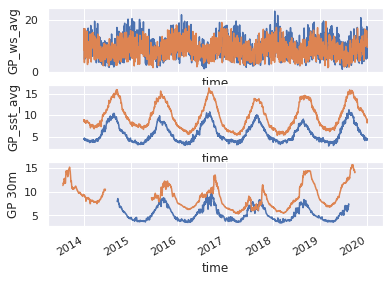

In [17]:
# Quick plot
fig,(ax1,ax2,ax3) = plt.subplots(3,1, sharex=True)
alldata.GI_ws_avg.plot(ax=ax1)
alldata.GP_ws_avg.plot(ax=ax1)
alldata.GI_sst_avg.plot(ax=ax2)
alldata.GP_sst_avg.plot(ax=ax2)
alldata['GI 30m'].plot(ax=ax3)
alldata['GP 30m'].plot(ax=ax3)

In [0]:
# 1 Week Average
alldata_1w = alldata.resample(time='1W').mean().to_dataframe()

## Plot the Data

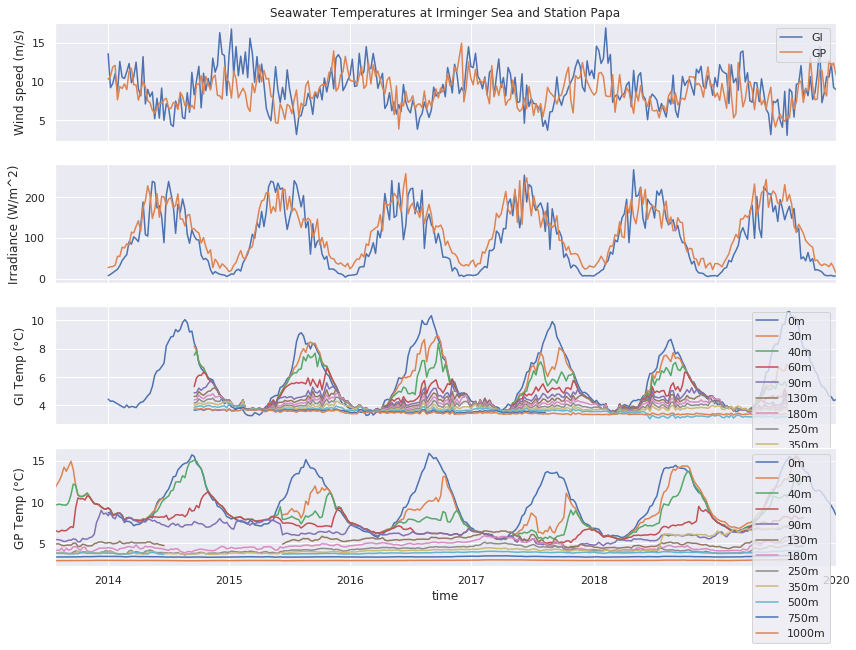

In [19]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(14,10))

# Winds
alldata_1w.GI_ws_avg.plot(ax=ax1,label='GI')
alldata_1w.GP_ws_avg.plot(ax=ax1,label='GP')
ax1.legend(loc=1)
ax1.set_ylabel('Wind speed (m/s)')

# Irradiance
alldata_1w.GI_irr_avg.plot(ax=ax2,label='GI')
alldata_1w.GP_irr_avg.plot(ax=ax2,label='GP')
ax1.legend(loc=1)
ax2.set_ylabel('Irradiance (W/m^2)')

# Temperature
alldata_1w['GI_sst_avg'].plot(ax=ax3,label='0m')
alldata_1w['GI 30m'].plot(ax=ax3,label='30m')
alldata_1w['GI 40m'].plot(ax=ax3,label='40m')
alldata_1w['GI 60m'].plot(ax=ax3,label='60m')
alldata_1w['GI 90m'].plot(ax=ax3,label='90m')
alldata_1w['GI 130m'].plot(ax=ax3,label='130m')
alldata_1w['GI 180m'].plot(ax=ax3,label='180m')
alldata_1w['GI 250m'].plot(ax=ax3,label='250m')
alldata_1w['GI 350m'].plot(ax=ax3,label='350m')
alldata_1w['GI 500m'].plot(ax=ax3,label='500m')
alldata_1w['GI 750m'].plot(ax=ax3,label='750m')
alldata_1w['GI 1000m'].plot(ax=ax3,label='1000m')
ax3.legend(loc=1)
ax3.set_ylabel('GI Temp (°C)')

alldata_1w['GP_sst_avg'].plot(ax=ax4,label='0m')
alldata_1w['GP 30m'].plot(ax=ax4,label='30m')
alldata_1w['GP 40m'].plot(ax=ax4,label='40m')
alldata_1w['GP 60m'].plot(ax=ax4,label='60m')
alldata_1w['GP 90m'].plot(ax=ax4,label='90m')
alldata_1w['GP 130m'].plot(ax=ax4,label='130m')
alldata_1w['GP 180m'].plot(ax=ax4,label='180m')
alldata_1w['GP 250m'].plot(ax=ax4,label='250m')
alldata_1w['GP 350m'].plot(ax=ax4,label='350m')
alldata_1w['GP 500m'].plot(ax=ax4,label='500m')
alldata_1w['GP 750m'].plot(ax=ax4,label='750m')
alldata_1w['GP 1000m'].plot(ax=ax4,label='1000m')
ax4.legend(loc=1)
ax4.set_ylabel('GP Temp (°C)')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

ax1.set_title('Seawater Temperatures at Irminger Sea and Station Papa');

plt.savefig('GIGP_MLD.png');

In [0]:
# Export to CSV
alldata_1w.to_csv('mld_application.csv')

## Appendix - Requesting Model Data
Data from ECMWF can be obtained using the following script.  Previoulsy we used ERA-Interium, but that was discontinued in Aug 2019, so now we need to use ERA5.  For more, see the [ERA5 CDS API Doc](https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5)

Note, in order for this to run on Colab, you will need to create a file at /root/.cdsapirc with your [api key](https://cds.climate.copernicus.eu/api-how-to).

In [0]:
# # First upload the file to your Colab workspace, then move it with this command
# ! mv /content/cdsapirc /root/.cdsapirc

In [0]:
# pip install cdsapi

In [0]:
# # Request ERA5 data for Irminger Sea area
# import cdsapi
# c = cdsapi.Client()
# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'variable': [
#             '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature',
#             'sea_surface_temperature', 'surface_solar_radiation_downwards',
#         ],
#         'year': [
#             '2014','2015', '2016', 
#             '2017','2018', '2019',
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '03:00', '06:00',
#             '09:00', '12:00', '15:00',
#             '18:00', '21:00',
#         ],
#         # 'area' : [61, -40, 59, -38], # North, West, South, East. Irminger
#         'area' : [51, -145, 49, -143], # North, West, South, East. Station Papa
#         'format': 'netcdf',
#     },
#     'era5data.nc')

In [0]:
# # Download datafile
# url_ecm = 'http://136.156.133.32/cache-compute-0009/cache/data7/adaptor.mars.internal-1579212914.3257482-24922-17-626b9dcc-598c-4be3-a5d0-0330354461ae.nc'
# from urllib.request import urlretrieve
# urlretrieve(url_ecm,'ecmdata.nc')